# Preprocessing 2 
Sample GSM7710088_C3N-00495-T1_CPT0078510004_snRNA_ccRCC 

In [120]:
import scanpy as sc
import tarfile
import gzip
import seaborn as sns
from scipy.io import mmread, mmwrite
import pandas as pd
import numpy as np

Set up paths and extract data.

In [121]:
file_path = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/GSM7710088_C3N-00495-T1_CPT0078510004_snRNA_ccRCC.tar"
output_path = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2"

In [122]:
with tarfile.open(file_path, "r") as tar:
    tar.extractall(path=output_path)
    print("Files extracted successfully")

Files extracted successfully


In [123]:
input1_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/barcodes.tsv.gz"
input2_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/features.tsv.gz"
input3_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/matrix.mtx.gz"
output1_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/barcodes.tsv"
output2_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/features.tsv"
output3_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/matrix.mtx"

In [124]:
with gzip.open(input1_file, "rt") as gz_file:  
    with open(output1_file, "w") as out_file:
        out_file.write(gz_file.read())

with gzip.open(input2_file, "rt") as gz_file:  
    with open(output2_file, "w") as out_file:
        out_file.write(gz_file.read())
        
with gzip.open(input3_file, "rt") as gz_file:  
    with open(output3_file, "w") as out_file:
        out_file.write(gz_file.read())

In [125]:
matrix = mmread(output3_file).T.tocsc() 


In [126]:
genes = pd.read_csv(output2_file, sep="\t", index_col= None, header=None)[1].values
barcodes_df = pd.read_csv(output1_file, sep="\t", index_col= None, header=None)[0].values
gene_id = pd.read_csv(output2_file, sep="\t", index_col= None, header=None)[0].values

In [127]:
sample_2 = sc.AnnData(
    X = matrix,
)

In [128]:
sample_2.obs_names = barcodes_df
sample_2.var_names = genes
sample_2.var['gene_id'] = gene_id

In [129]:
sample_2

AnnData object with n_obs × n_vars = 940788 × 36601
    var: 'gene_id'

# Create the annotation (2)

In [139]:
df = pd.read_csv('/Users/isabelgiray/Desktop/Annotation_1.csv', delimiter=';')

In [140]:
df_filtered = df[df['GEO.sample'] == 'C3N-00495-T1_CPT0078510004_snRNA_ccRCC']

In [141]:
annotation = df_filtered[['Barcode','cell_type.harmonized.cancer']]

In [142]:
barcodes = annotation['Barcode']

In [143]:
sample_2_filtered = sample_2[sample_2.obs.index.isin(barcodes)].copy()

In [144]:
sample_2_ann = pd.merge(sample_2_filtered.obs, annotation, left_index=True, right_on='Barcode',how='inner')

In [145]:
sample_2_filtered.obs = sample_2_ann.set_index('Barcode')

In [146]:
sample_2_filtered

AnnData object with n_obs × n_vars = 6577 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'cell_type.harmonized.cancer'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Actual preprocessing following the scanpy tutorial. (1)

In [130]:
sample_2.var_names_make_unique()

When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cellMark mitochondrial genes, as they important for quality analysis. We mark mitochondrial genes:

In [131]:
sample_2.var['mt'] = sample_2.var_names.str.startswith('MT-')

Calculate QC metrics:

In [132]:
sc.pp.calculate_qc_metrics(
    sample_2, qc_vars=['mt'], inplace=True, percent_top=[20],log1p=True
)
sample_2

AnnData object with n_obs × n_vars = 940788 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

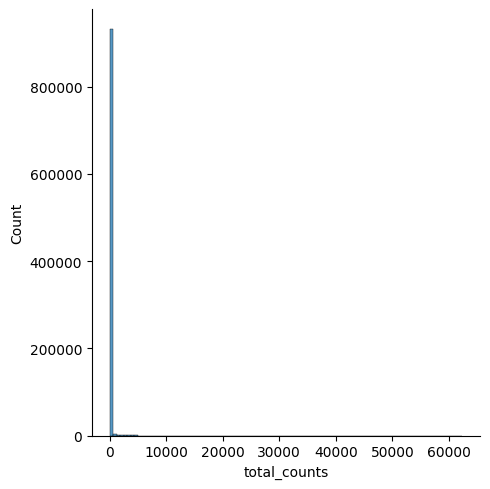

In [133]:
p1 = sns.displot(sample_2.obs["total_counts"], bins=100, kde=False)

-> We have to filter out many low quality cells since the plot shows a high number of cells with zero total counts.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


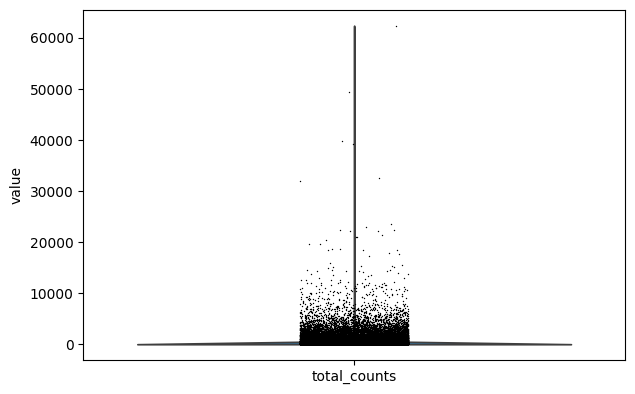

In [34]:
sc.pl.violin(sample_2, 'total_counts')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


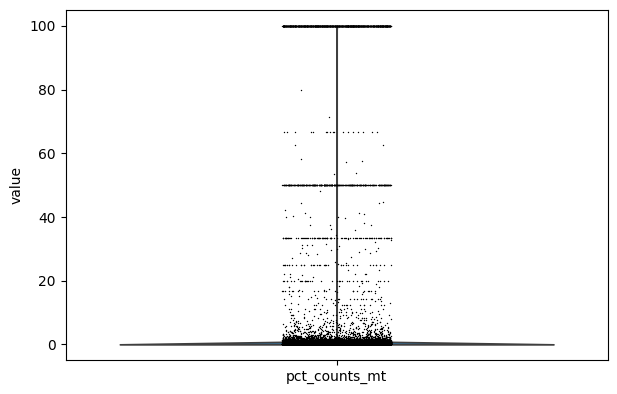

In [35]:
p2 = sc.pl.violin(sample_2, "pct_counts_mt")

pct_counts_mt: represents the percentage of mitochondrial gene expression as a propoortion of total counts for each cell.
The violin is widest near 0, indicating that most cells have very low mitochondrial percentages. These are likely high-quality cells. Some cells have extremely high mitochondrial percentages. Common cut-off for pct_counts_mt is 10–20%. -> 20%

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


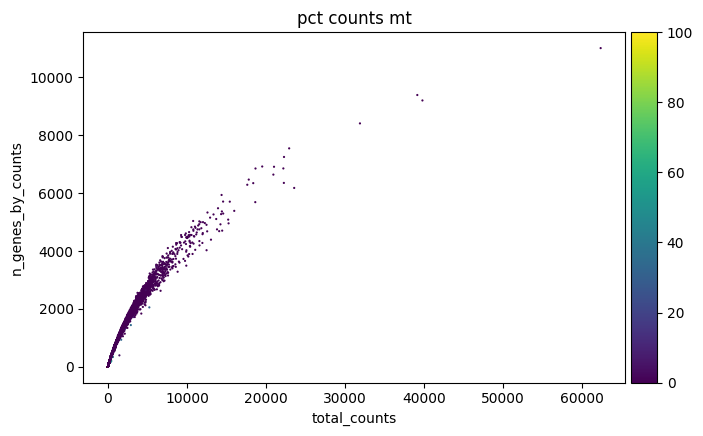

In [36]:
p3 = sc.pl.scatter(sample_2, "total_counts", "n_genes_by_counts", color="pct_counts_mt",size=10)

Low total_counts with high pct_counts_mt: Likely poor-quality cells with few genes expressed, dominated by mitochondrial transcripts.
High total_counts with high pct_counts_mt: Could indicate potential doublets or multiplets (artifacts where multiple cells are captured together).

Like mentioned in the paper we filter out cells that that have less than 200 genes expressed:

In [134]:
sc.pp.filter_cells(sample_2, min_genes=200)
sc.pp.filter_cells(sample_2, max_genes=10000)

In [135]:
sample_2 = sample_2[sample_2.obs['total_counts'] >= 1000, :]
sample_2 = sample_2[sample_2.obs['total_counts'] <= 80000, :]

In [136]:
sample_2 = sample_2[sample_2.obs['pct_counts_mt'] < 10, :]

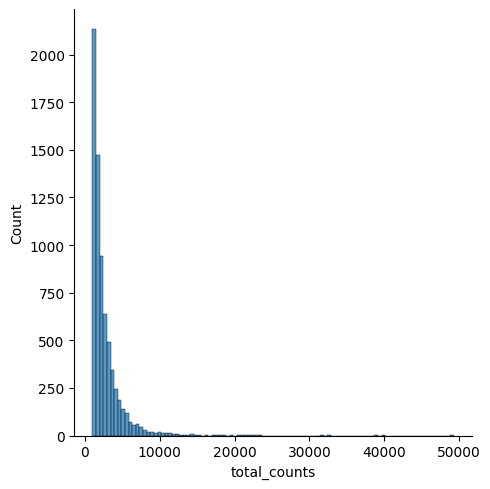

In [137]:
p1 = sns.displot(sample_2.obs["total_counts"], bins=100, kde=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


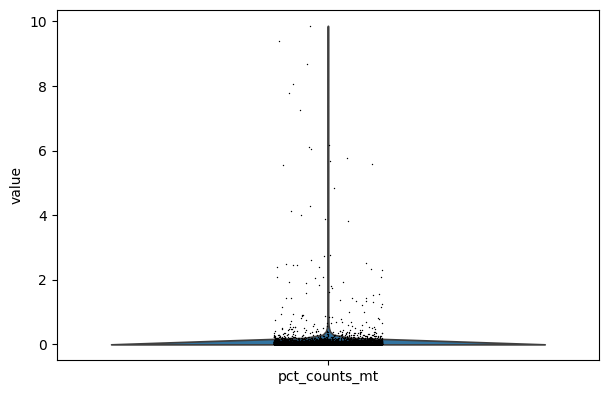

In [138]:
p2 = sc.pl.violin(sample_2, "pct_counts_mt")

# Normalization (3)

In [147]:
sc.pp.normalize_total(sample_2_filtered)
sc.pp.log1p(sample_2_filtered)

In [148]:
sc.pp.highly_variable_genes(sample_2_filtered, n_top_genes=2000)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In the context of single-cell RNA sequencing (scRNA-seq), highly variable genes are important because they can help differentiate cells from one another based on their gene expression profiles.

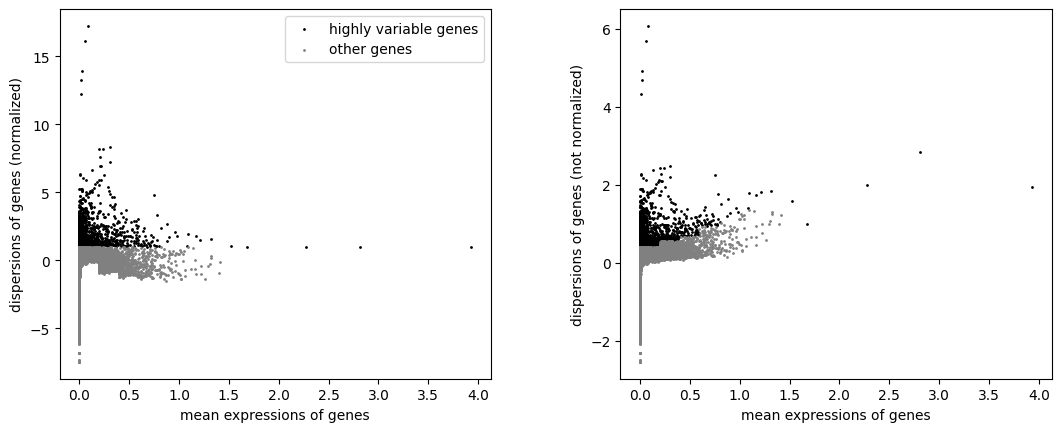

In [149]:
sc.pl.highly_variable_genes(sample_2_filtered)

In [150]:
sample_2_filtered = sample_2_filtered[:, sample_2_filtered.var.highly_variable]

In [151]:
sample_2_filtered

View of AnnData object with n_obs × n_vars = 6577 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'cell_type.harmonized.cancer'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


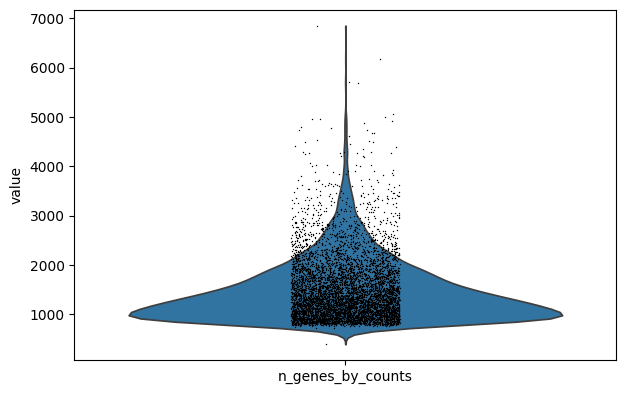

In [152]:
p2 = sc.pl.violin(sample_2_filtered, "n_genes_by_counts")

Dimensionality reduction

In [153]:
sc.tl.pca(sample_2_filtered)

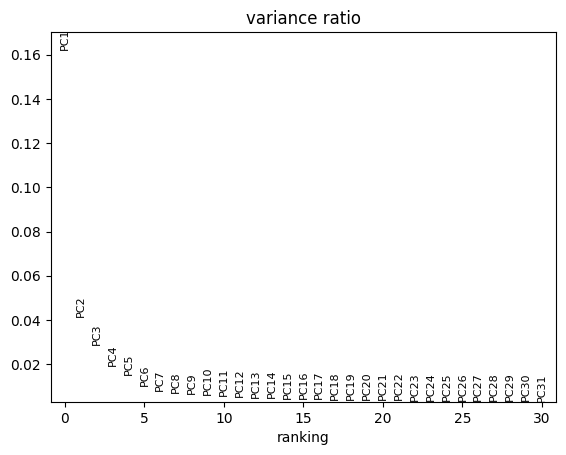

In [154]:
sc.pl.pca_variance_ratio(sample_2_filtered)

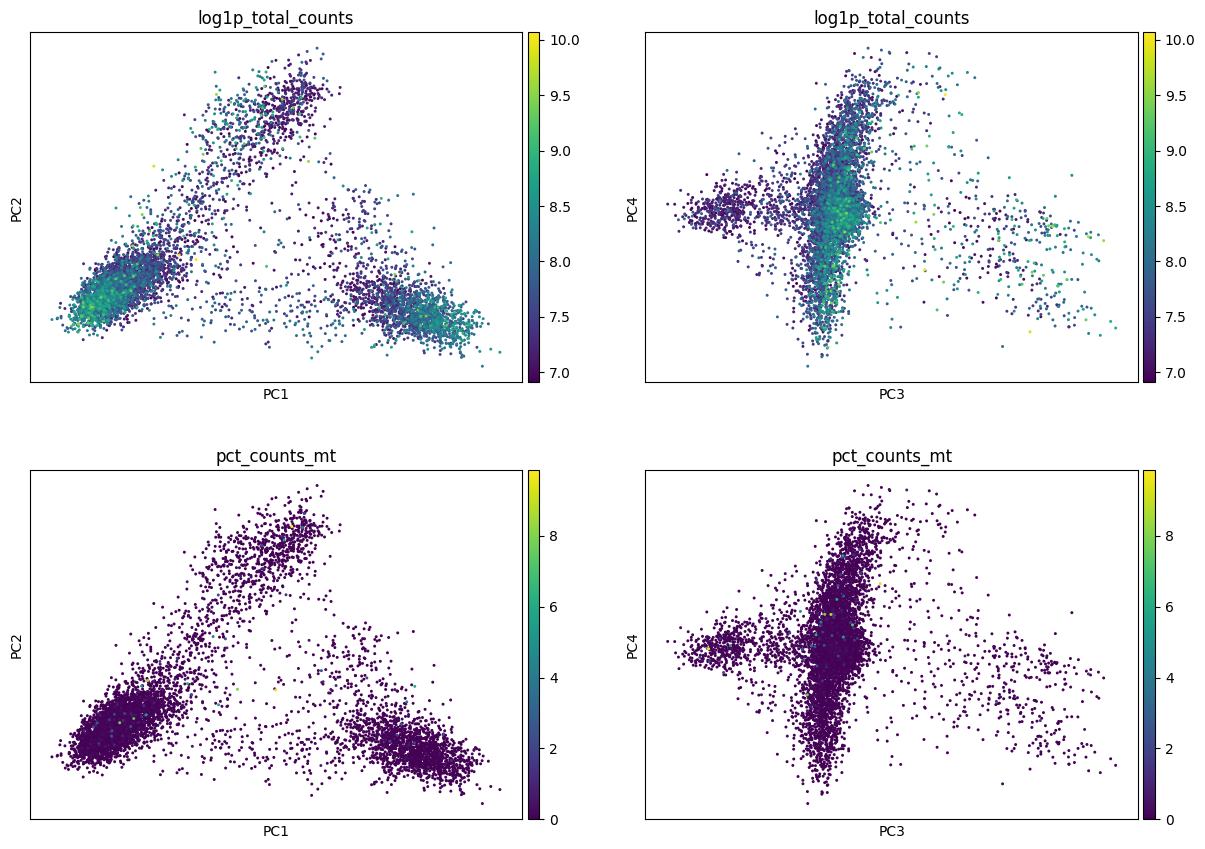

In [155]:
sc.pl.pca(
    sample_2_filtered,
    color=["log1p_total_counts"] * 2 + ["pct_counts_mt"] * 2,
    dimensions=[(0, 1), (2, 3)] * 2,
    ncols=2,
    # size=2,
)

In [156]:
sc.pp.neighbors(sample_2_filtered)

In [157]:
sc.tl.umap(sample_2_filtered)

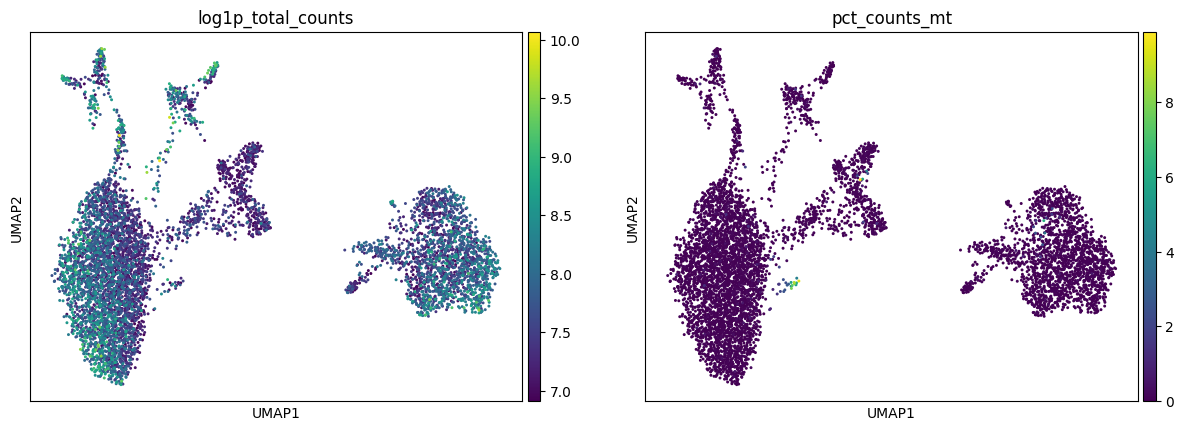

In [158]:
sc.pl.umap(
    sample_2_filtered,
    color=["log1p_total_counts", "pct_counts_mt"]
)# Check principal comp.

In [159]:
sc.tl.leiden(sample_2_filtered)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


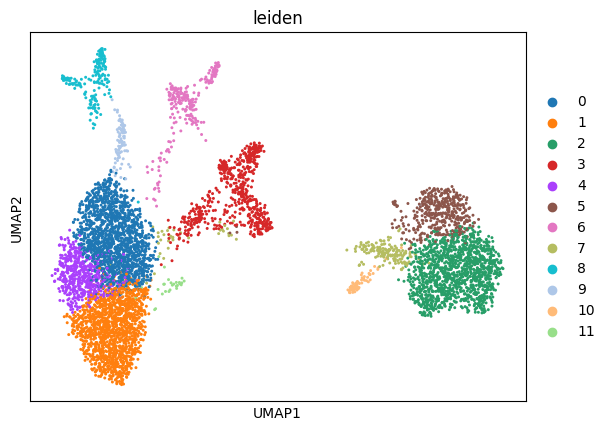

In [160]:
sc.pl.umap(sample_2_filtered, color="leiden")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


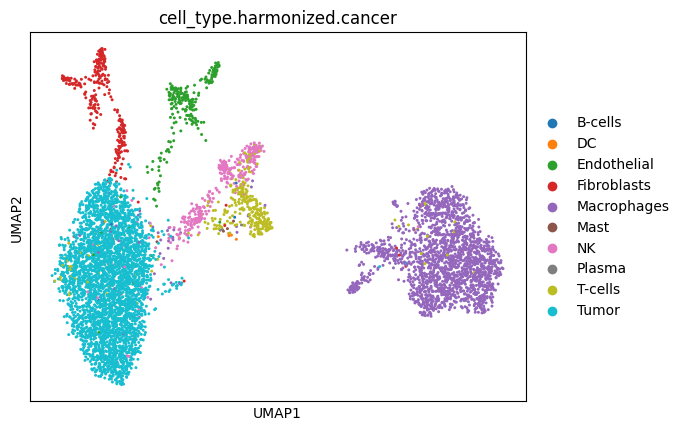

In [129]:
sc.pl.umap(sample_2_filtered,color=['cell_type.harmonized.cancer'])

# Create tsv for further use

In [162]:
sample_2_filtered

AnnData object with n_obs × n_vars = 6577 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'cell_type.harmonized.cancer', 'leiden'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type.harmonized.cancer_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [163]:
barcodes = sample_2_filtered.obs.index
gene_ids = sample_2_filtered.var['gene_id']

In [164]:
expression_matrix = sample_2_filtered.X
if not isinstance(expression_matrix, np.ndarray):
    expression_matrix = expression_matrix.toarray() 

In [165]:
data = pd.DataFrame(
    {
        'barcode': np.repeat(barcodes, len(gene_ids)),
        'gene_id': np.tile(gene_ids, len(barcodes)),
        'expression_count': expression_matrix.flatten()
    }
)

In [166]:
data

,barcode,gene_id,expression_count
0,AAACCCAAGCGTACAG-1,ENSG00000186891,0.0
1,AAACCCAAGCGTACAG-1,ENSG00000169962,0.0
2,AAACCCAAGCGTACAG-1,ENSG00000177133,0.0
3,AAACCCAAGCGTACAG-1,ENSG00000162591,0.0
4,AAACCCAAGCGTACAG-1,ENSG00000235169,0.0
...,...,...,...
13153995,TTTGTTGTCGTCCATC-1,ENSG00000212907,0.0
13153996,TTTGTTGTCGTCCATC-1,ENSG00000198886,0.0
13153997,TTTGTTGTCGTCCATC-1,ENSG00000198786,0.0
13153998,TTTGTTGTCGTCCATC-1,ENSG00000198727,0.0


In [167]:
data = data[data['expression_count'] != 0]

In [168]:
data

,barcode,gene_id,expression_count
8,AAACCCAAGCGTACAG-1,ENSG00000116285,0.792842
83,AAACCCAAGCGTACAG-1,ENSG00000233008,0.792842
135,AAACCCAAGCGTACAG-1,ENSG00000185630,0.792842
137,AAACCCAAGCGTACAG-1,ENSG00000198821,1.229446
174,AAACCCAAGCGTACAG-1,ENSG00000263961,0.792842
...,...,...,...
13153831,TTTGTTGTCGTCCATC-1,ENSG00000101384,0.977021
13153855,TTTGTTGTCGTCCATC-1,ENSG00000042062,0.977021
13153871,TTTGTTGTCGTCCATC-1,ENSG00000215386,1.461647
13153935,TTTGTTGTCGTCCATC-1,ENSG00000188158,0.977021


In [169]:
mean_expression = data['expression_count'].mean()

# Create a new column 'classification' based on the mean
data['classification'] = data['expression_count'].apply(
    lambda x: 'high' if x > mean_expression else 'low'
)

/var/folders/n3/_wp662b56svdfm7y3bsyc4bh0000gn/T/ipykernel_47446/2038249924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['classification'] = data['expression_count'].apply(


In [170]:
data

,barcode,gene_id,expression_count,classification
8,AAACCCAAGCGTACAG-1,ENSG00000116285,0.792842,low
83,AAACCCAAGCGTACAG-1,ENSG00000233008,0.792842,low
135,AAACCCAAGCGTACAG-1,ENSG00000185630,0.792842,low
137,AAACCCAAGCGTACAG-1,ENSG00000198821,1.229446,high
174,AAACCCAAGCGTACAG-1,ENSG00000263961,0.792842,low
...,...,...,...,...
13153831,TTTGTTGTCGTCCATC-1,ENSG00000101384,0.977021,high
13153855,TTTGTTGTCGTCCATC-1,ENSG00000042062,0.977021,high
13153871,TTTGTTGTCGTCCATC-1,ENSG00000215386,1.461647,high
13153935,TTTGTTGTCGTCCATC-1,ENSG00000188158,0.977021,high


In [171]:
data = data.reset_index(drop=True)

In [172]:
data

,barcode,gene_id,expression_count,classification
0,AAACCCAAGCGTACAG-1,ENSG00000116285,0.792842,low
1,AAACCCAAGCGTACAG-1,ENSG00000233008,0.792842,low
2,AAACCCAAGCGTACAG-1,ENSG00000185630,0.792842,low
3,AAACCCAAGCGTACAG-1,ENSG00000198821,1.229446,high
4,AAACCCAAGCGTACAG-1,ENSG00000263961,0.792842,low
...,...,...,...,...
814742,TTTGTTGTCGTCCATC-1,ENSG00000101384,0.977021,high
814743,TTTGTTGTCGTCCATC-1,ENSG00000042062,0.977021,high
814744,TTTGTTGTCGTCCATC-1,ENSG00000215386,1.461647,high
814745,TTTGTTGTCGTCCATC-1,ENSG00000188158,0.977021,high


In [173]:
classification_counts = data['classification'].value_counts()

In [174]:
classification_counts

classification
low     501386
high    313361
Name: count, dtype: int64

In [175]:
data.to_csv('/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/final_C3N-00495-T1_CPT0078510004_snRNA_ccRCC.tsv', sep='\t', index=False)

In [151]:
sample_2_filtered.var_names[sample_2_filtered.var_names.duplicated()]

Index([], dtype='object')

In [150]:
gene_id = sample_2_filtered.var_names.get_loc('MALAT1')
cell_id = sample_2_filtered.obs_names.get_loc('CCTTGTGCACTCATAG-1')

AttributeError: 'DataFrame' object has no attribute 'get_loc'

In [149]:
sample_2_filtered[cell_id,gene_id].X.todense()

matrix([[2.7863586]], dtype=float32)